In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [32]:
"Read in data"
df = pd.read_csv("car_sales_data.csv")

In [33]:
print("Shape:", df.shape)
print("\nColumns & dtypes:\n", df.dtypes)

Shape: (50000, 7)

Columns & dtypes:
 Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Price                    int64
dtype: object


In [34]:
"Adding features"

age = df["Car_Age"] = 2022 - df["Year of manufacture"] # avoid division by zero -> turn 0 age into NaN

df["Mileage_per_Year"] = df["Mileage"].div(age)

# replace any remaining inf with NaN, then fill with total mileage
df["Mileage_per_Year"] = (
    df["Mileage_per_Year"]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(df["Mileage"])
)


In [35]:
#check duplicates
print("Total duplicates:", df.duplicated().sum())


duplicates = df[df.duplicated()] #display all duplicate rows
print(duplicates)


Total duplicates: 12
      Manufacturer   Model  Engine size Fuel type  Year of manufacture  \
5426            VW    Polo          1.2    Petrol                 2003   
9862          Ford  Mondeo          1.4    Diesel                 1987   
14745          BMW      Z4          2.4    Petrol                 1999   
19020       Toyota   Yaris          1.0    Petrol                 1996   
19337           VW    Polo          1.0    Petrol                 2000   
23927           VW    Polo          1.2    Petrol                 2021   
25368           VW    Golf          1.2    Diesel                 2011   
28576           VW    Polo          1.2    Petrol                 2003   
34246           VW  Passat          2.0    Diesel                 2003   
35647         Ford   Focus          1.6    Petrol                 2019   
41536           VW  Passat          1.8    Diesel                 1996   
45904         Ford  Fiesta          1.2    Petrol                 2003   

       Mileage  

In [36]:
"Duplicates"

#drop duplicates
df = df.drop_duplicates()

print("After dropping exact duplicates:", df.shape)


After dropping exact duplicates: (49988, 9)


In [37]:
"check missing values per column"

print("\nMissing values per column:\n", df.isna().sum())

inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
print("\nInfinite values per numeric column:\n", inf_counts)

# Combined check (NaN + Inf)
bad_values = df.isna().sum() + np.isinf(df.select_dtypes(include=[np.number])).reindex(df.columns, fill_value=0)
print("\nTotal problematic values (NaN + Inf) per column:\n", bad_values)



Missing values per column:
 Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
Car_Age                0
Mileage_per_Year       0
dtype: int64

Infinite values per numeric column:
 Engine size            0
Year of manufacture    0
Mileage                0
Price                  0
Car_Age                0
Mileage_per_Year       0
dtype: int64

Total problematic values (NaN + Inf) per column:
                     Car_Age Engine size  Fuel type  Manufacturer Mileage  \
Manufacturer              0           0        NaN           NaN       0   
Model                     0           0        NaN           NaN       0   
Engine size               0           0        NaN           NaN       0   
Fuel type                 0           0        NaN           NaN       0   
Year of manufacture       0           0        NaN           NaN       0   
Mileage                  

# Data visualisations

Cars per manufacturer:
              Count  Percentage
Manufacturer                   
Ford          14956       29.92
VW            14906       29.82
Toyota        12553       25.11
BMW            4964        9.93
Porsche        2609        5.22


/var/folders/by/bn5byyk92gq6f173m_jc7qym0000gn/T/ipykernel_41546/238748735.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


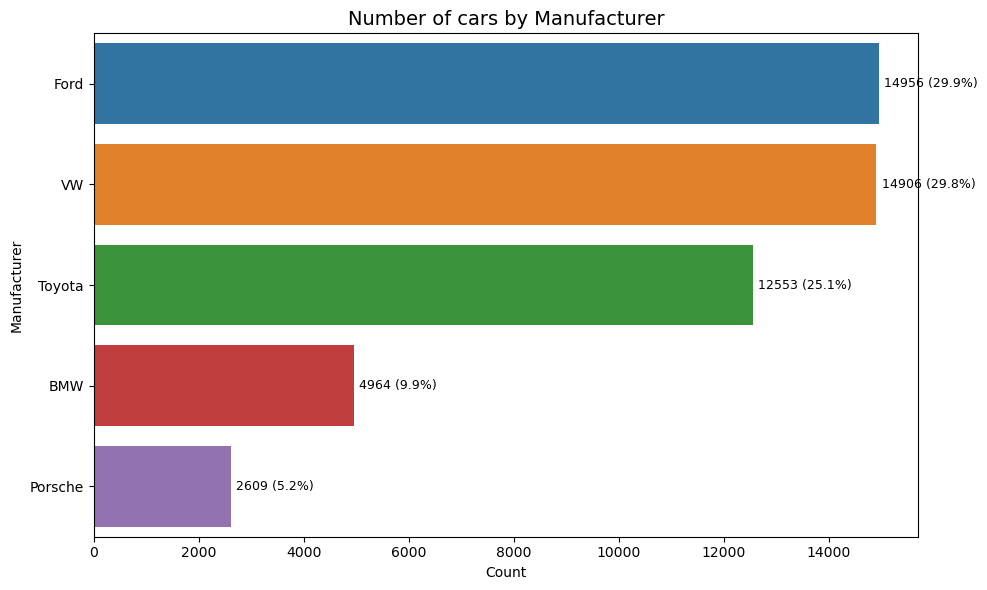

In [38]:
"Number and percentage of every manufacturer"

# Group by manufacturer and count
counts = df["Manufacturer"].value_counts()

counts_df = counts.rename("Count").to_frame()
counts_df["Percentage"] = (counts_df["Count"] / counts_df["Count"].sum() * 100).round(2)

print("Cars per manufacturer:")
print(counts_df)

#plot
plt.figure(figsize=(10,6))
palette = sns.color_palette("tab10", n_colors=len(counts_df))

sns.barplot(
    y=counts_df.index,
    x=counts_df["Count"],
    palette=palette
)

plt.title("Number of cars by Manufacturer", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Manufacturer")

for i, (count, pct) in enumerate(zip(counts_df["Count"], counts_df["Percentage"])):
    plt.text(count + 100, i, f"{count} ({pct:.1f}%)",
             ha="left", va="center", fontsize=9)

plt.tight_layout()
plt.show()



Sorted with percentages:

Manufacturer      Model  count  percentage
         BMW         Z4   1687       33.98
         BMW         M5   1645       33.14
         BMW         X3   1632       32.88
        Ford     Mondeo   5057       33.81
        Ford      Focus   4975       33.26
        Ford     Fiesta   4924       32.92
     Porsche        911    872       33.42
     Porsche    Cayenne    870       33.35
     Porsche 718 Cayman    867       33.23
      Toyota       RAV4   4292       34.19
      Toyota      Prius   4171       33.23
      Toyota      Yaris   4090       32.58
          VW       Golf   5049       33.87
          VW       Polo   4988       33.46
          VW     Passat   4869       32.66


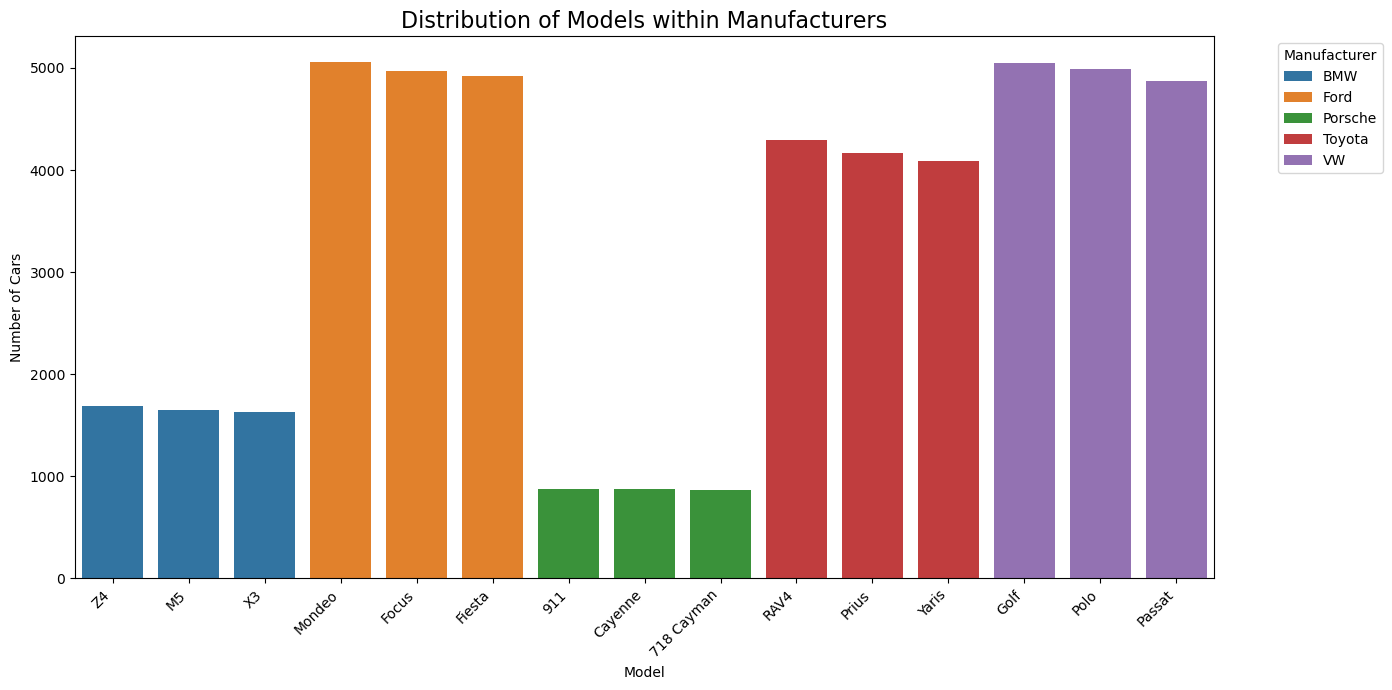

In [39]:
"Number and percentage of every model"

#Group by Manufacturer and Model
brand_model_counts = (
    df.groupby(["Manufacturer", "Model"])
      .size()
      .reset_index(name="count")
)

brand_model_counts["percentage"] = (
    brand_model_counts
    .groupby("Manufacturer")["count"]
    .transform(lambda x: (x / x.sum() * 100).round(2))
)

#Sort by manufacturer
brand_model_counts = brand_model_counts.sort_values(
    ["Manufacturer", "count"], ascending=[True, False]
).reset_index(drop=True)

print("\nSorted with percentages:\n")
print(brand_model_counts.to_string(index=False))

#Plot
plt.figure(figsize=(14, 7))
sns.barplot(
    data=brand_model_counts,
    x="Model",
    y="count",
    hue="Manufacturer",
    dodge=False,
    palette="tab10"
)
plt.title("Distribution of Models within Manufacturers", fontsize=16)
plt.ylabel("Number of Cars")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Manufacturer", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [40]:
"Identify numeric and categorical cols"

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)



Numeric columns: ['Engine size', 'Year of manufacture', 'Mileage', 'Price', 'Car_Age', 'Mileage_per_Year']
Categorical columns: ['Manufacturer', 'Model', 'Fuel type']


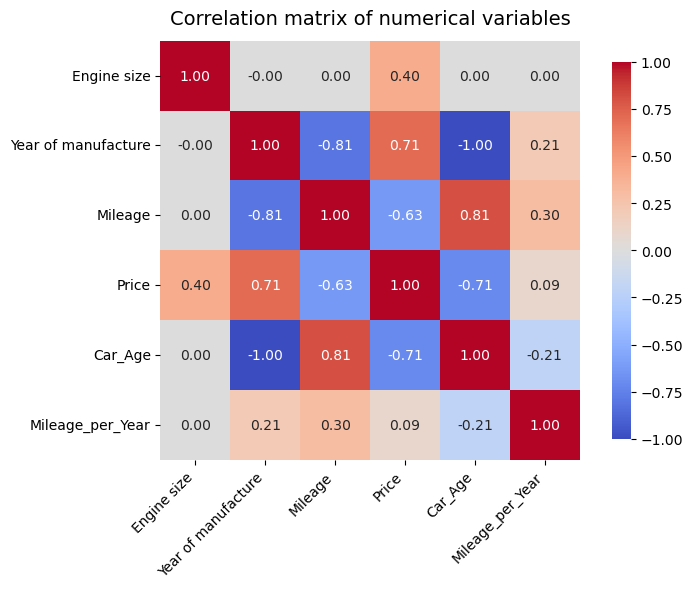

In [41]:
"Correlation matrix of numerical fuetures"

#only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

corr = numeric_cols.corr(method="pearson").round(2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm", vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": 0.9}
)
ax.set_title("Correlation matrix of numerical variables", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Training NN

In [42]:
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [43]:
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [44]:
"Prepare preprocessing pipelines"

numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()


numeric_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="median")),
   ("scaler", StandardScaler(with_mean=False))  # with_mean=False to work well even if we end up with sparse matrix
])


categorical_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="most_frequent")),
   ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


preprocessor = ColumnTransformer(
   transformers=[
       ("num", numeric_transformer, numeric_features),
       ("cat", categorical_transformer, categorical_features),
   ],
   remainder="drop"
)


In [45]:
"Regressor: Multi-layer Perceptron (Neural Net)"

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    random_state=42,
    max_iter=500,
    early_stopping=True,       # internal validation 10% of X_train
    validation_fraction=0.1,   
    n_iter_no_change=15,
    learning_rate="adaptive"
)

In [46]:
"Build Pipeline"

model = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("regressor", mlp)
])

In [47]:
"Train model"
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Engine size',
                                                   'Year of manufacture',
                                                   'Mileage', 'Car_Age',
                                                   'Mileage_per_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Manufacturer', 'Model',
                                                   'Fuel type'])])),
                ('regressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(128, 64),
                              learning_rate='adaptive', max_iter=500,
                              n_iter_no_change=15, random_state=42))])

In [48]:
"Evaluate model with metrics"

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.8f}")
print(f"RMSE: {rmse:.8f}")
print(f"R²  : {r2:.8f}")


MAE : 399.04198650
RMSE: 705.48711422
R²  : 0.99816143


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


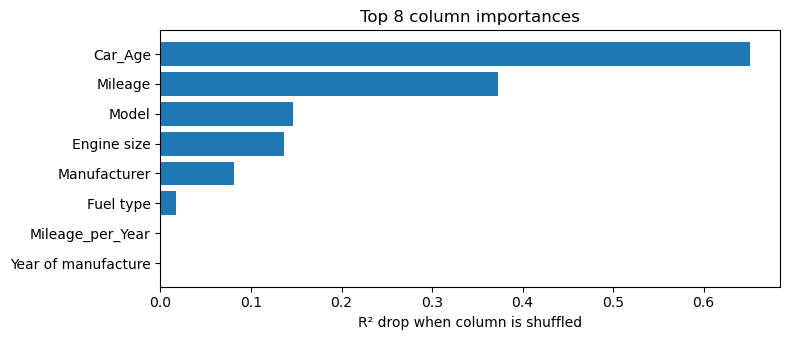

,column,importance
6,Car_Age,0.651729
5,Mileage,0.373295
1,Model,0.146720
2,Engine size,0.135914
0,Manufacturer,0.080918
3,Fuel type,0.016914
7,Mileage_per_Year,0.000181
4,Year of manufacture,0.000088


In [49]:
"Feature importance plot"

def importance_plot(pipe, X, y, n_repeats=5, top_n=10, random_state=42):
    rng = np.random.default_rng(random_state)
    base = pipe.score(X, y) 

    drops = {
        col: base - np.mean([
            pipe.score(X.assign(**{col: rng.permutation(X[col].values)}), y)
            for _ in range(n_repeats)
        ])
        for col in X.columns
    }

    imp = (pd.DataFrame({"column": drops.keys(), "importance": drops.values()})
             .sort_values("importance", ascending=False)
             .head(top_n))

    plt.figure(figsize=(8, max(3.5, 0.4*len(imp))))
    plt.barh(imp["column"][::-1], imp["importance"][::-1])
    plt.xlabel("R² drop when column is shuffled")
    plt.title(f"Top {len(imp)} column importances")
    plt.tight_layout()
    plt.show()
    return imp


importance_plot(model, X_test, y_test, n_repeats=5, top_n=10)


In [50]:
df = df.drop(columns=["Year of manufacture", "Mileage_per_Year"])

## Re-train NN with selected features

In [51]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.feature_selection import SelectKBest, f_regression   # selector
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error

selected_x = df.drop(columns=[target_col])
selected_y = df[target_col].astype(float)

In [52]:
X = selected_x
y = selected_y

# Rebuild the preprocessors so they’re refit per fold
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

In [53]:
# Your MLP (same hyperparams you used)
mlp2 = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    random_state=42,
    max_iter=500,
    early_stopping=True,      # uses only the training fold internally
    validation_fraction=0.1,
    n_iter_no_change=15,
    learning_rate="adaptive"
)


In [54]:
selector = SelectKBest(score_func=f_regression, k=100)  # <-- adjust k or tune it below

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("regressor", mlp2)
])

In [56]:
# --- CV with feature selection INSIDE the pipeline ---



# X_selected, y_selected should be your current (possibly narrowed) dataframe/series
# If you still have X_train_selected/X_test_selected from a prior split, IGNORE those here:



# NEW: selector lives inside the pipeline, after preprocessing


# 5-fold CV (shuffle since this isn’t time series)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error"
}

cv_res = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

print("R2 (test) per fold:", cv_res["test_r2"])
print("MAE (test) per fold:", -cv_res["test_mae"])
print("RMSE (test) per fold:", -cv_res["test_rmse"])
print("\nR2  mean±std:  %.4f ± %.4f" % (cv_res["test_r2"].mean(), cv_res["test_r2"].std()))
print("MAE mean±std:  %.2f ± %.2f" % ((-cv_res["test_mae"]).mean(), (-cv_res["test_mae"]).std()))
print("RMSE mean±std: %.2f ± %.2f" % ((-cv_res["test_rmse"]).mean(), (-cv_res["test_rmse"]).std()))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warni

R2 (test) per fold: [0.99901593 0.99917387 0.9988041  0.99858238 0.99908167 0.99874449
 0.99871262 0.99902687 0.99866089 0.99911312]
MAE (test) per fold: [236.12870337 230.13316469 265.24435283 297.15210003 249.66413538
 306.23625914 296.64234246 248.76587754 301.35273874 237.66525676]
RMSE (test) per fold: [512.149602   476.52613105 540.2352619  605.79624191 510.46174497
 614.88077166 571.26754322 521.67646812 588.95868823 492.57965688]

R2  mean±std:  0.9989 ± 0.0002
MAE mean±std:  266.90 ± 28.84
RMSE mean±std: 543.45 ± 46.32


In [57]:
from sklearn.model_selection import permutation_test_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

score, perm_scores, pvalue = permutation_test_score(
    pipe, selected_x, selected_y,
    scoring="r2", cv=cv, n_permutations=200, n_jobs=-1, random_state=42
)
print("Normal CV R2:", score)
print("Permutation mean R2:", perm_scores.mean())
print("p-value:", pvalue)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=26. All the features will be returned.
  warni

Normal CV R2: 0.9985714022082698
Permutation mean R2: -0.0004993858227426109
p-value: 0.004975124378109453


In [58]:
# Fast duplicate probe
dups = selected_x.duplicated(keep=False).sum()
print("Exact duplicate rows (X only):", dups)


Exact duplicate rows (X only): 0


In [59]:
from sklearn.model_selection import GroupKFold

groups = selected_x["Manufacturer"].astype(str) + " | " + selected_x["Model"].astype(str)
gkf = GroupKFold(n_splits=5)

from sklearn.model_selection import cross_validate
scores = cross_validate(
    pipe, selected_x, selected_y,
    cv=gkf.split(selected_x, selected_y, groups=groups),
    scoring={"r2":"r2", "rmse":"neg_root_mean_squared_error"},
    n_jobs=-1
)
print("Grouped-CV R2:", scores["test_r2"].mean(), "±", scores["test_r2"].std())
print("Grouped-CV RMSE:", (-scores["test_rmse"]).mean())


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=21. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=23. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=23. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=23. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=24. All the features will be returned.
  warni

Grouped-CV R2: 0.8225710108978088 ± 0.0828351859663055
Grouped-CV RMSE: 6169.536221712184


In [ ]:
import numpy as np
import pandas as pd

# crude correlation screen on numeric columns
num_cols = selected_x.select_dtypes(include=["number"]).columns
corrs = pd.Series({c: abs(np.corrcoef(selected_x[c], selected_y)[0,1]) for c in num_cols}).sort_values(ascending=False)
print(corrs.head(10))


In [22]:
# Split: 80% train, 20% test
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [23]:
"Prepare preprocessing pipelines"

numeric_features = X_train_selected.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train_selected.select_dtypes(include=["object"]).columns.tolist()


numeric_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="median")),
   ("scaler", StandardScaler(with_mean=False))  # with_mean=False to work well even if we end up with sparse matrix
])


categorical_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="most_frequent")),
   ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


preprocessor = ColumnTransformer(
   transformers=[
       ("num", numeric_transformer, numeric_features),
       ("cat", categorical_transformer, categorical_features),
   ],
   remainder="drop"
)


In [24]:
"Regressor: Multi-layer Perceptron (Neural Net)"

mlp_selected = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    random_state=42,
    max_iter=500,
    early_stopping=True,       # internal validation 10% of X_train
    validation_fraction=0.1,   
    n_iter_no_change=15,
    learning_rate="adaptive"
)

In [25]:
"Build Pipeline"

model_selected = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("regressor", mlp_selected)
])

In [26]:
model_selected.fit(X_train_selected, y_train_selected)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Engine size',
                                                   'Year of manufacture',
                                                   'Mileage', 'Car_Age',
                                                   'Mileage_per_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Manufacturer', 'Model',
                                                   'Fuel type'])])),
                ('regressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(128, 64),
                              learning_rate='adaptive', max_iter=500,
                              n_iter_no_change=15, random_state=42))])

In [27]:
"Evaluate model with metrics"

y_pred_selected = model_selected.predict(X_test_selected)

mae  = mean_absolute_error(y_test_selected, y_pred_selected)
rmse = mean_squared_error(y_test_selected, y_pred_selected, squared=False)
r2   = r2_score(y_test_selected, y_pred_selected)

print(f"MAE : {mae:.8f}")
print(f"RMSE: {rmse:.8f}")
print(f"R²  : {r2:.8f}")

MAE : 399.04198650
RMSE: 705.48711422
R²  : 0.99816143


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
"For faster predictions later"

joblib.dump(model, "car_price_mlp.joblib")        # save
model = joblib.load("car_price_mlp.joblib")       # load later

In [29]:
def predict_one(pipe, Manufacturer, Model, FuelType, Year, Mileage, EngineSize, Car_Age, Mileage_per_Year) :
    df = pd.DataFrame([{
        "Manufacturer": Manufacturer,
        "Model": Model,
        "Fuel type": FuelType,
        "Year of manufacture": Year,
        "Mileage": Mileage,
        "Engine size": EngineSize,
        "Car Age": Car_Age,
        "Mileage per Year": Mileage_per_Year


    }])
   
    return float(pipe.predict(df)[0])

In [30]:
price = predict_one(model, "Toyota", "Corolla", "Petrol", 2019, 35000, 1.8, 3, 6365.000000)
print(price)

ValueError: columns are missing: {'Mileage_per_Year', 'Car_Age'}

In [ ]:
"Saker kvar att göra"
"- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV"
"- Cross-validation"
"Fåt ner MAE och RMSE och upp R² nån mer decimal"